<a href="https://colab.research.google.com/github/bootneck2000/Yolo_FCNN_dev_pengos/blob/main/Faster_RCNN_test_pengo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

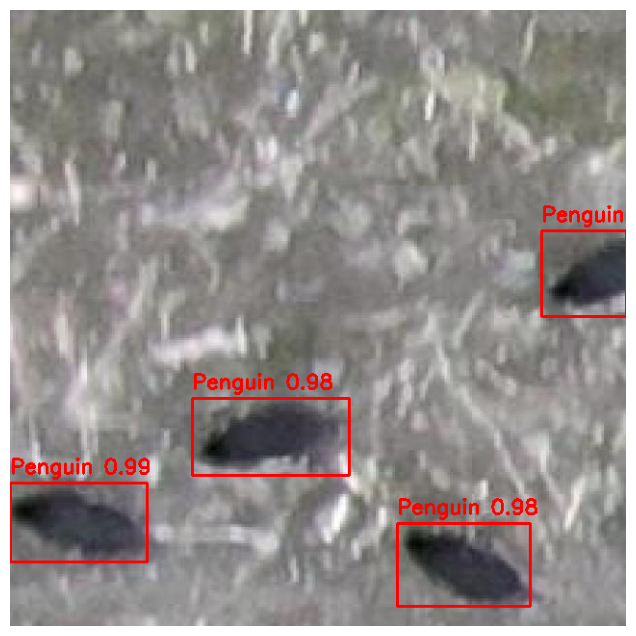

Predictions for: test_1_6_jpg.rf.09d0076c68c1549512339f554fd47011.jpg


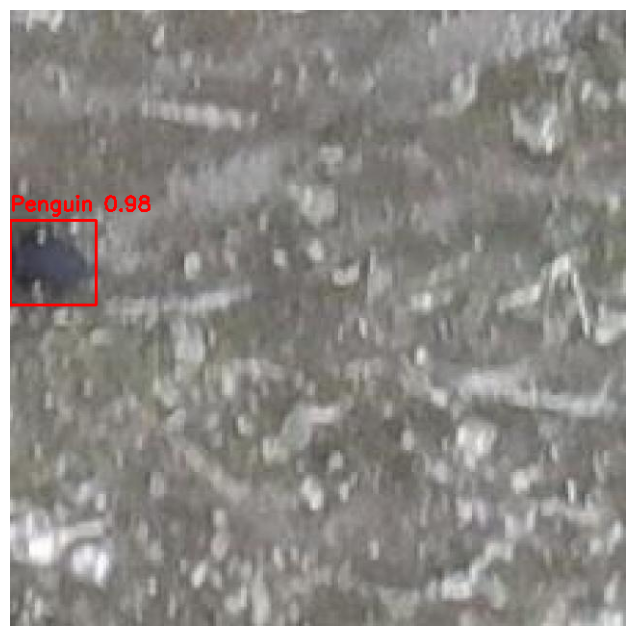

Predictions for: test_10_6_jpg.rf.f36a2ff540236768da3b38dd48553e47.jpg


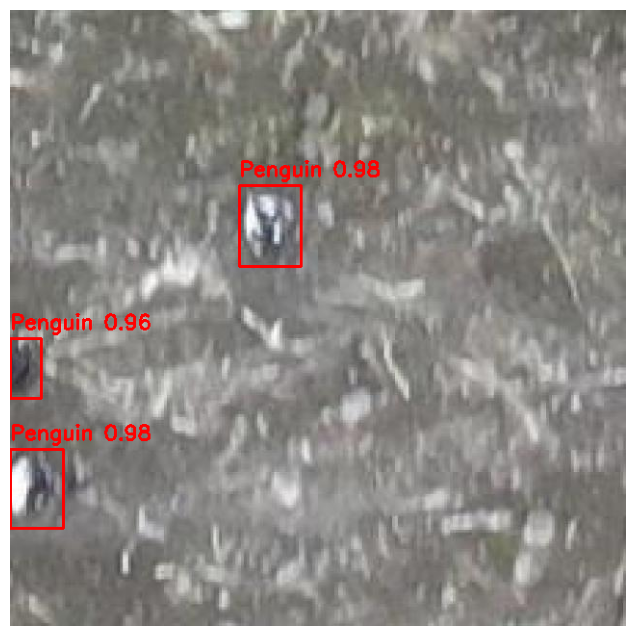

Predictions for: test_9_7_jpg.rf.0e8099ea25d18c7a16763a01f3665dfe.jpg


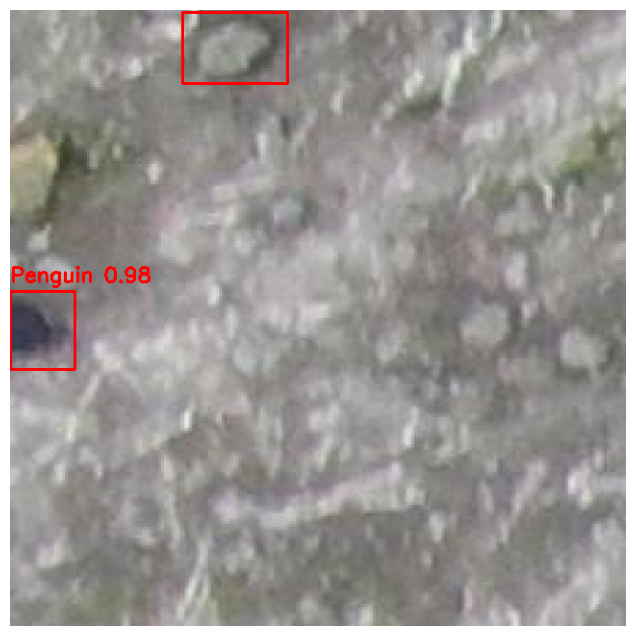

Predictions for: test_0_4_jpg.rf.4dea8317d59ce97ef0468b4d067f1d91.jpg


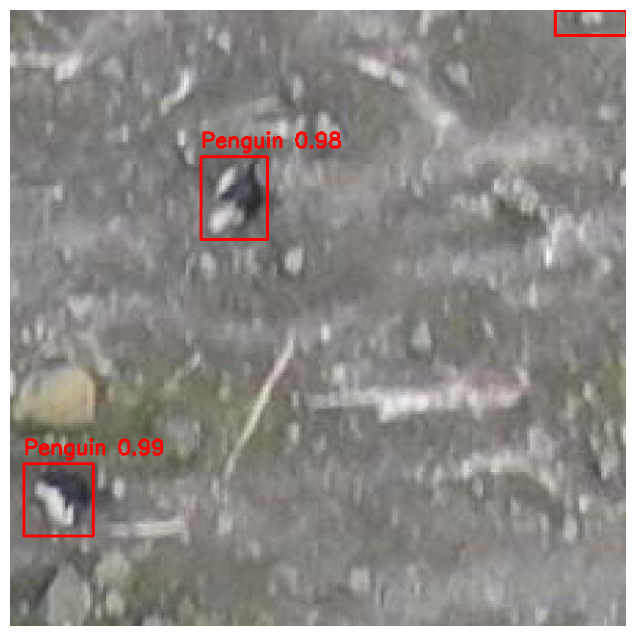

Predictions for: test_11_4_jpg.rf.7997af1cad388d9637ec6492058b9b52.jpg


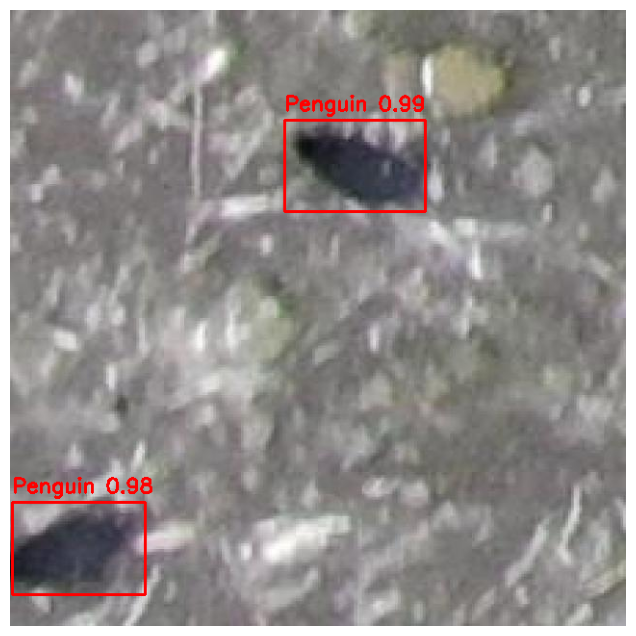

Predictions for: test_0_10_jpg.rf.da83073eee2d4edb8b4089eddc59c308.jpg


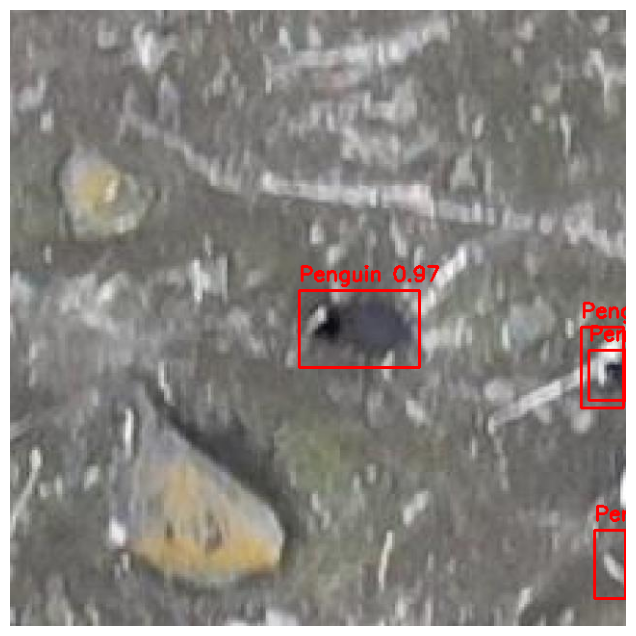

Predictions for: test_8_7_jpg.rf.f72df36ad24c2df52fab88131b749f79.jpg


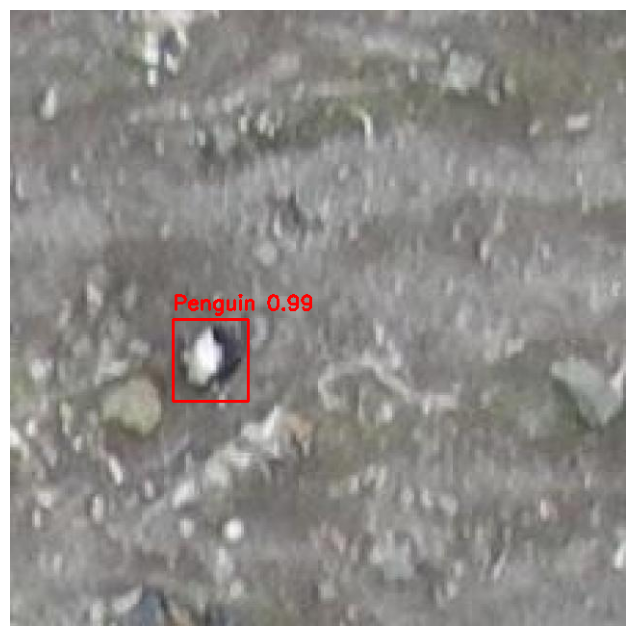

Predictions for: test_12_4_jpg.rf.5f0e3983f0313d4b0aeda9cca46d1440.jpg


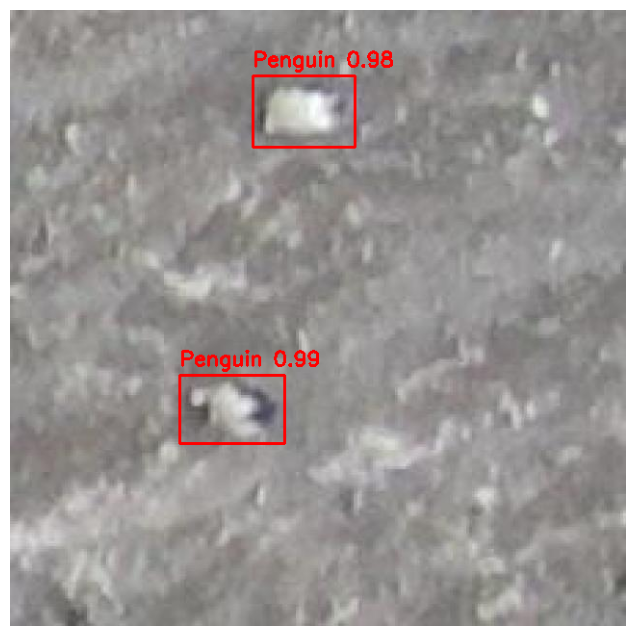

Predictions for: test_17_6_jpg.rf.476019c0c51a22fe3e5e0eb05c3bf380.jpg


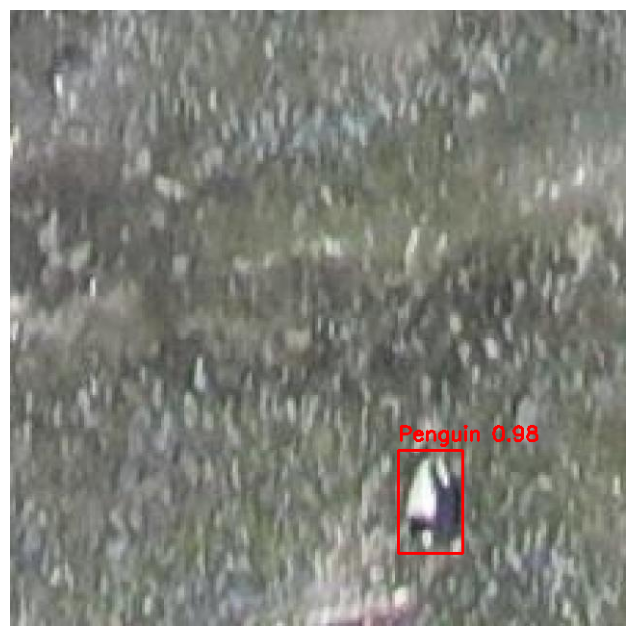

Predictions for: test_9_13_jpg.rf.90373d1e86951b3dbb98a381f8181fc3.jpg


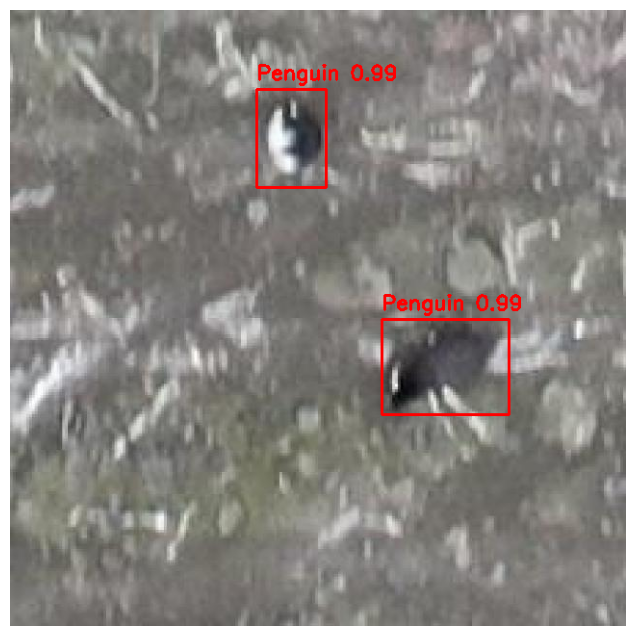

Predictions for: test_8_9_jpg.rf.bda1a88fc576aa212c5f01b115913f90.jpg


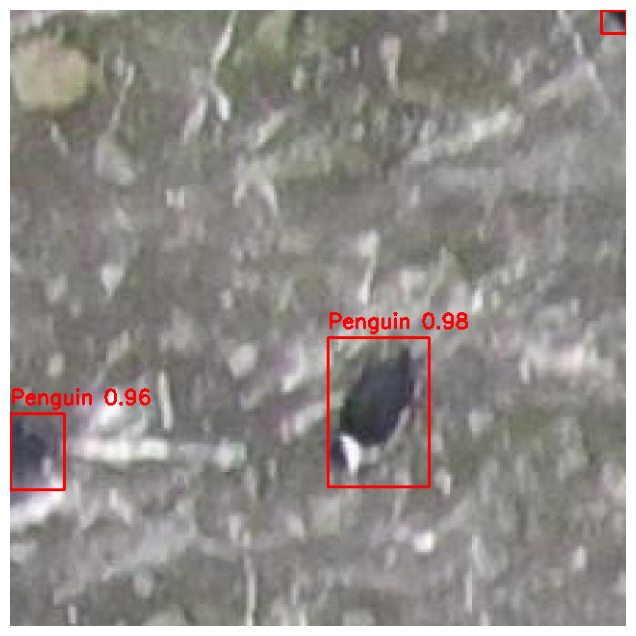

Predictions for: test_1_5_jpg.rf.4ecab8ca02985ce9bd2eac431f14425c.jpg


In [ ]:
import torch
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# --- Helper: Visualization ---
def plot_image_with_boxes(img, boxes, labels=None, scores=None, class_dict=None, score_threshold=0.5):
    plt.figure(figsize=(8,8))
    img = np.array(img).copy()
    for i, box in enumerate(boxes):
        if scores is not None and scores[i] < score_threshold:
            continue
        xmin, ymin, xmax, ymax = [int(x) for x in box]
        color = (255,0,0)
        img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, 2)
        label = ""
        if labels is not None and class_dict is not None:
            label = list(class_dict.keys())[list(class_dict.values()).index(labels[i]-1)]  # -1 for background
        if scores is not None:
            label += f" {scores[i]:.2f}"
        if label:
            cv2.putText(img, label, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

# --- Load the trained model ---
def get_fasterrcnn_model(num_classes):
    import torchvision
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# --- Load dataset for test split ---
class RoboflowYolo8Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, split='test', transforms=None):
        self.data_dir = data_dir
        self.split = split
        self.transforms = transforms

        self.images_dir = os.path.join(self.data_dir, self.split, "images")
        self.image_files = [f for f in os.listdir(self.images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        self.class_dict = self._parse_class_names()

    def _parse_class_names(self):
        yaml_path = os.path.join(self.data_dir, "data.yaml")
        import yaml
        with open(yaml_path, "r") as f:
            ydata = yaml.safe_load(f)
        names = ydata.get("names") or ydata.get("nc")
        if isinstance(names, dict):
            names = [names[k] for k in sorted(names)]
        return {name: idx for idx, name in enumerate(names)}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transforms:
            image = self.transforms(image)
        else:
            image = F.to_tensor(image)
        return image, img_name

# --- Inference ---
import cv2

# Set the DATASET_DIR to the same as in training, and the test split (change if needed)
DATASET_DIR = "roboflow_dataset"  # Update if your test set is in a nested folder
TEST_SPLIT = "test"  # Change if your folder is named differently

# Load test dataset
test_dataset = RoboflowYolo8Dataset(DATASET_DIR, split=TEST_SPLIT)
class_dict = test_dataset.class_dict
num_classes = len(class_dict) + 1

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_fasterrcnn_model(num_classes)
model.load_state_dict(torch.load("fasterrcnn_roboflow_yolov8.pth", map_location=device))
model.eval()
model.to(device)

# Run inference on test images and display predictions
for idx in range(len(test_dataset)):
    image, img_name = test_dataset[idx]
    image_tensor = image.to(device)
    with torch.no_grad():
        prediction = model([image_tensor])[0]
    boxes = prediction['boxes'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    # Visualize
    pil_img = F.to_pil_image(image)
    plot_image_with_boxes(pil_img, boxes, labels, scores, class_dict, score_threshold=0.5)
    print(f"Predictions for: {img_name}")
    # Show only first N if you want
    # if idx > 9: break